In [64]:
import pdb
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pydci import PCAMUDProblem
from pydci.utils import add_noise, put_df

# <center> ADCIRC Example - Data-Consistent Inversion </center>

___
<font color='blue'><center>**Carlos del-Castillo-Negrete, Rylan Spence**</center></font>
    <br>
    <center>University of Texas at Austin
    <br>
    carlos.delcastillo@utexas.edu, rylan.spence@utexas.edu</center>
___

- [***Parameter Estimation with Maximal Updated Densities***](https://arxiv.org/pdf/2212.04587.pdf) Pilosov, M., del-Castillo-Negrete, C., Yen, T. Y., Butler, T., & Dawson, C. (2022). Parameter Estimation with Maximal Updated Densities. arXiv preprint arXiv:2212.04587.
___


<cite id="e9b62"><a href="#zotero%7C11450669%2F7F6J6S7U">(Wicks &#38; Atkinson, 2017)</a></cite>


____

## Getting dataset

If running from within DesignSafe, data should be under the project directory PRJ-3492 at the path `~/NHERI-Published/PRJ-3492/` in your jupyter instance.

Otherwise [download published dataset](https://doi.org/10.17603/ds2-bmrf-y737) and place in same path as this notebook.

In [65]:
!ls ~/NHERI-Published/PRJ-3492/

ls: cannot access '/home/jovyan/NHERI-Published/PRJ-3492/': No such file or directory


In [66]:
path = str(Path.home() / "NHERI-Published/PRJ-3492/si-inlet-full-ds.pickle")
path = str(Path.cwd() / "si-inlet-full-ds.pickle")

with open(path, "rb") as fp:
    full_ds = pickle.load(fp)
    
all_lam = np.vstack([full_ds["lam"], full_ds["lam_ref"].reshape(1, -1)])
all_data = np.vstack([full_ds["data"], full_ds["true_vals"].reshape(1, -1)])
all_lam.shape, all_data.shape

((1000, 2), (1000, 6133))

In [67]:
def build_dataset(lam_true_idx=-1, num_samples=999, std_dev=0.05, seed=None):
    """
    Build Dataset
    """
    measurements = add_noise(all_data[[lam_true_idx]], std_dev, seed=seed).reshape(
        -1, 1
    )
    data_df = pd.DataFrame(full_ds["times"], columns=["ts"])
    data_df["shift_idx"] = 0
    data_df["sample_flag"] = True
    for i, val in enumerate(all_lam[lam_true_idx]):
        data_df[f"lam_true_{i}"] = val
    data_df = put_df(data_df, "q_lam_true", all_data[lam_true_idx].reshape(-1, 1))
    data_df = put_df(data_df, "q_lam_obs", measurements)

    sample_idxs = list(range(len(all_lam)))
    lam_true_idx = len(all_lam) - 1 if lam_true_idx == -1 else lam_true_idx
    sample_idxs.remove(lam_true_idx)
    sample_idxs = np.random.choice(sample_idxs, num_samples, replace=False)

    lam_df = pd.DataFrame(
        all_lam[sample_idxs],
        columns=[f"lam_{i}" for i in range(len(full_ds["lam"][0]))],
    )
    q_lam_df = pd.DataFrame(
        all_data[sample_idxs],
        columns=[f"q_lam_{i}" for i in range(len(full_ds["data"][0]))],
    )
    samples_df = pd.concat([lam_df, q_lam_df], axis=1)

    return data_df, samples_df, measurements

In [68]:
def plot_state(data, samples=None, mask=None, plot_intervals=None):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))

    mask = data.index.values if mask is None else mask
    sns.lineplot(data.iloc[mask], x="ts", y="q_lam_true_0", label="True State", ax=ax)
    sns.scatterplot(
        data.iloc[mask],
        x="ts",
        y="q_lam_obs_0",
        marker="*",
        label="Observed State",
        ax=ax,
    )

    if samples is not None:
        cols = [
            c
            for c in samples.columns
            if c.startswith("q_lam_") and int(c.split("_")[-1]) in mask
        ]
        num_plot = 10
        for idx, i in enumerate(
            np.random.choice(range(len(samples)), num_plot, replace=False)
        ):
            to_plot = pd.DataFrame(
                samples.iloc[[i]][cols].values.T, columns=[f"q_lam_s={i}"]
            )
            to_plot["ts"] = data.iloc[mask]["ts"].values
            label = None if idx != num_plot - 1 else "Samples"
            sns.lineplot(
                to_plot,
                x="ts",
                y=f"q_lam_s={i}",
                ax=ax,
                color="r",
                alpha=0.1,
                label=label,
            )

    plot_intervals = [] if plot_intervals is None else plot_intervals
    for name, args, intervals in plot_intervals:
        for interval in intervals:
            ax.axvline(data["ts"][interval[0]], **args)
        args["label"] = name
        ax.axvline(data["ts"][intervals[-1][-1]], **args)

    # ax.set_title('Time Window 3')
    # ax.set_title(f'lam_true = {data["lam_true_0"].values[0]}, {data["lam_true_1"].values[0]}')
    ax.set_ylabel("Water Elevation (m)")
    ax.set_xlabel("Time")
    ax.legend()

In [69]:
def plot_params(state_df):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    prob.plot_L(df=state_df, param_idx=0, lam_true=[full_ds["lam_ref"]], ax=ax[0])
    prob.plot_L(df=state_df, param_idx=1, lam_true=[full_ds["lam_ref"]], ax=ax[1])

    return ax

In [70]:
def split_range(mask, n_splits=2):
    return [range(x[0], x[-1]) for x in np.array_split(t3_mask, n_splits)]

In [71]:
def plot_iterations(prob, max_plot=10, plot_idxs=None, lam_true=None):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    if plot_idxs is None:
        num_its = prob.pca_states["iteration"].max()
        if num_its > max_plot:
            plot_idxs = list(range(0, num_its, int(num_its / max_plot)))
            if (num_its - 1) not in plot_idxs:
                plot_idxs += [num_its - 1]
        else:
            plot_idxs = range(0, num_its)

    label = f"$\pi^{{in}}_{0}$"
    sns.kdeplot(prob.state, x="lam_0", ax=ax[0], label=label)
    sns.kdeplot(prob.state, x="lam_1", ax=ax[1], label=label)
    for idx, state in prob.pca_states.groupby("iteration"):
        if idx in plot_idxs:
            label = f"$\pi^{{up}}_{{{idx}}}$"
            sns.kdeplot(
                state,
                x="lam_0",
                weights=state["weight"] * state["ratio"],
                ax=ax[0],
                label=label,
            )
            sns.kdeplot(
                state,
                x="lam_1",
                weights=state["weight"] * state["ratio"],
                ax=ax[1],
                label=label,
            )

    if lam_true is not None:
        ax[0].axvline(
            lam_true[0], color="k", linestyle="--", label=f"$\lambda^{{\dagger}}$"
        )
        ax[1].axvline(
            lam_true[1], color="k", linestyle="--", label=f"$\lambda^{{\dagger}}$"
        )

    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel("$\lambda_1$")
    ax[1].set_xlabel("$\lambda_2$")

In [72]:
std_dev = 0.05
seed = 21
data_df, samples_df, measurements = build_dataset(
    seed=seed, std_dev=std_dev
)

In [73]:
data_df

,ts,shift_idx,sample_flag,lam_true_0,lam_true_1,q_lam_true_0,q_lam_obs_0
0,2018-01-01 00:03:00,0,True,0.067243,0.002568,-0.160002,-0.162600
1,2018-01-01 00:06:00,0,True,0.067243,0.002568,-0.159192,-0.164751
2,2018-01-01 00:09:00,0,True,0.067243,0.002568,-0.158108,-0.106019
3,2018-01-01 00:12:00,0,True,0.067243,0.002568,-0.156425,-0.219262
4,2018-01-01 00:15:00,0,True,0.067243,0.002568,-0.154186,-0.116916
...,...,...,...,...,...,...,...
6128,2018-01-13 23:45:00,0,True,0.067243,0.002568,-0.156296,-0.126368
6129,2018-01-13 23:48:00,0,True,0.067243,0.002568,-0.167302,-0.212053
6130,2018-01-13 23:51:00,0,True,0.067243,0.002568,-0.178476,-0.254657
6131,2018-01-13 23:54:00,0,True,0.067243,0.002568,-0.189576,-0.240698


In [74]:
samples_df

,lam_0,lam_1,q_lam_0,q_lam_1,q_lam_2,q_lam_3,q_lam_4,q_lam_5,q_lam_6,q_lam_7,...,q_lam_6123,q_lam_6124,q_lam_6125,q_lam_6126,q_lam_6127,q_lam_6128,q_lam_6129,q_lam_6130,q_lam_6131,q_lam_6132
0,0.093865,0.002217,-0.098529,-0.098187,-0.097603,-0.096297,-0.094471,-0.092910,-0.092280,-0.092804,...,-0.031317,-0.040351,-0.050015,-0.060054,-0.070415,-0.081188,-0.092421,-0.103996,-0.115751,-0.127697
1,0.073952,0.002513,-0.149888,-0.149366,-0.148671,-0.147051,-0.144599,-0.142349,-0.141211,-0.141387,...,-0.096050,-0.105088,-0.114628,-0.124460,-0.134574,-0.145131,-0.156176,-0.167739,-0.179283,-0.191110
2,0.059847,0.001664,0.009024,0.009842,0.010425,0.010887,0.011452,0.011629,0.010814,0.008978,...,0.088413,0.079203,0.069547,0.059593,0.049343,0.038682,0.027550,0.016001,0.004138,-0.007969
3,0.040349,0.001561,0.030676,0.031019,0.031184,0.031288,0.031271,0.030790,0.029591,0.027613,...,0.109560,0.100329,0.090722,0.080934,0.070816,0.060206,0.049101,0.037551,0.025542,0.013429
4,0.049240,0.003691,-0.115084,-0.112887,-0.110688,-0.107900,-0.104600,-0.101529,-0.099412,-0.098575,...,-0.053479,-0.063066,-0.073423,-0.084119,-0.095033,-0.106318,-0.118181,-0.130594,-0.143590,-0.156585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0.060459,0.002982,-0.180696,-0.177620,-0.174413,-0.170387,-0.165490,-0.160565,-0.157006,-0.155492,...,-0.128567,-0.137712,-0.147994,-0.159056,-0.170856,-0.183221,-0.195793,-0.208266,-0.221700,-0.235379
995,0.049044,0.002823,-0.113886,-0.111741,-0.109616,-0.106887,-0.103613,-0.100548,-0.098421,-0.097572,...,-0.051925,-0.061532,-0.071904,-0.082644,-0.093631,-0.104994,-0.116927,-0.129399,-0.142426,-0.155378
996,0.036092,0.002299,-0.036399,-0.034519,-0.032745,-0.030712,-0.028603,-0.027022,-0.026373,-0.026784,...,0.038204,0.028407,0.017975,0.007227,-0.003762,-0.015099,-0.026851,-0.038969,-0.051372,-0.064029
997,0.076454,0.002550,-0.157459,-0.156550,-0.155543,-0.154001,-0.151789,-0.149445,-0.147780,-0.147443,...,-0.102618,-0.112080,-0.122103,-0.132250,-0.142370,-0.153046,-0.163931,-0.175075,-0.186152,-0.198172


# Time Window 3

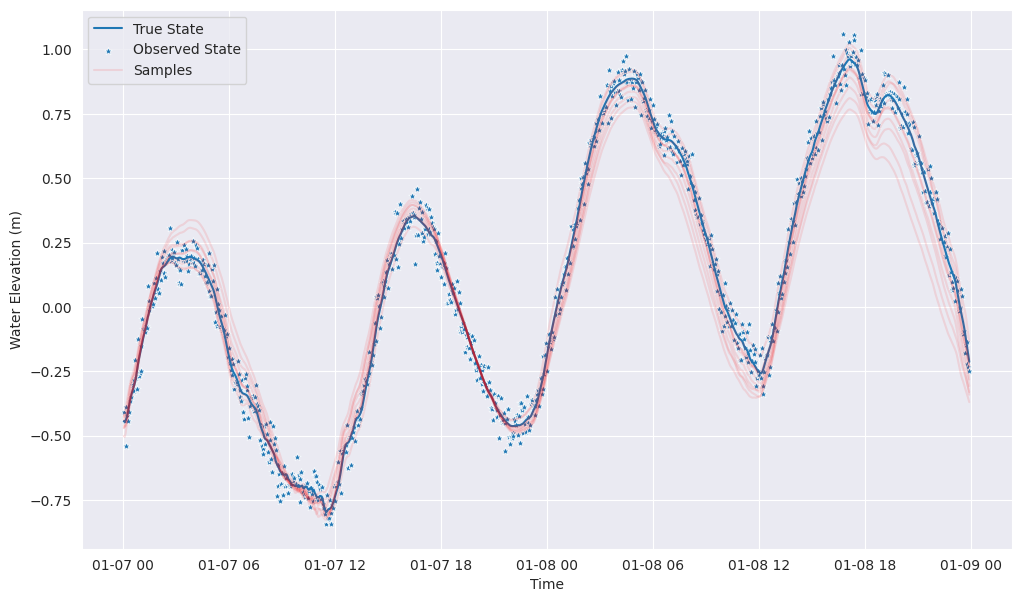

In [75]:
t3 = ["2018-01-07 00:00:00", "2018-01-09 00:00:00"]
t3_mask = data_df.index[(data_df["ts"] > t3[0]) & (data_df["ts"] < t3[1])].values
t3_mask = range(min(t3_mask), max(t3_mask))
plot_state(data_df, samples_df, t3_mask)

### Solving Using $Q_{PCA}$ Map

In [76]:
pca = PCAMUDProblem(samples_df, measurements, std_dev)
pca.set_weights([])
pca.solve(pca_components=[0, 1], pca_mask=t3_mask)
pca.result

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask
0,0.909367,5.935895,0.069212,0.002584,439,"[0, 1]","range(2774, 3732)"


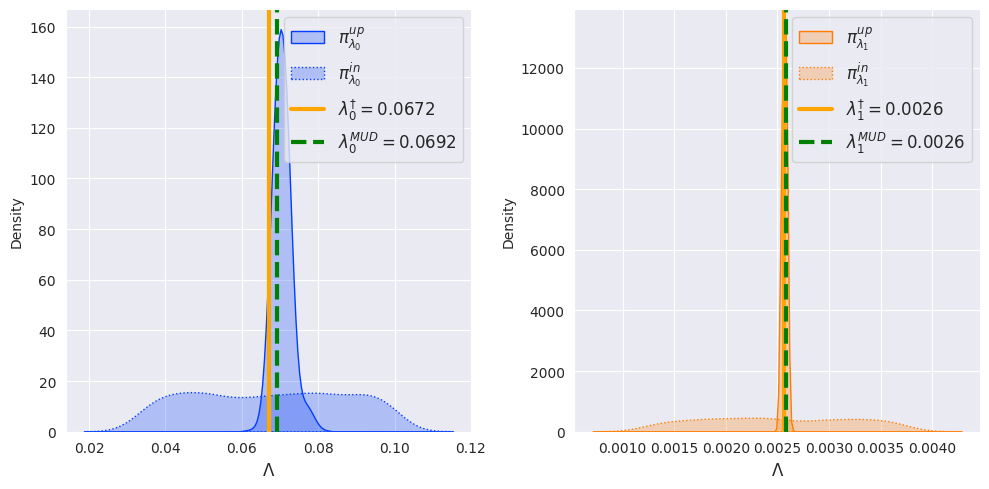

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
pca.plot_L(param_idx=0, lam_true=[full_ds["lam_ref"]], ax=ax[0])
pca.plot_L(param_idx=1, lam_true=[full_ds["lam_ref"]], ax=ax[1])
plt.savefig('adcirc_lam_density_no_split.png')

## Using 2, 5, 10 splits

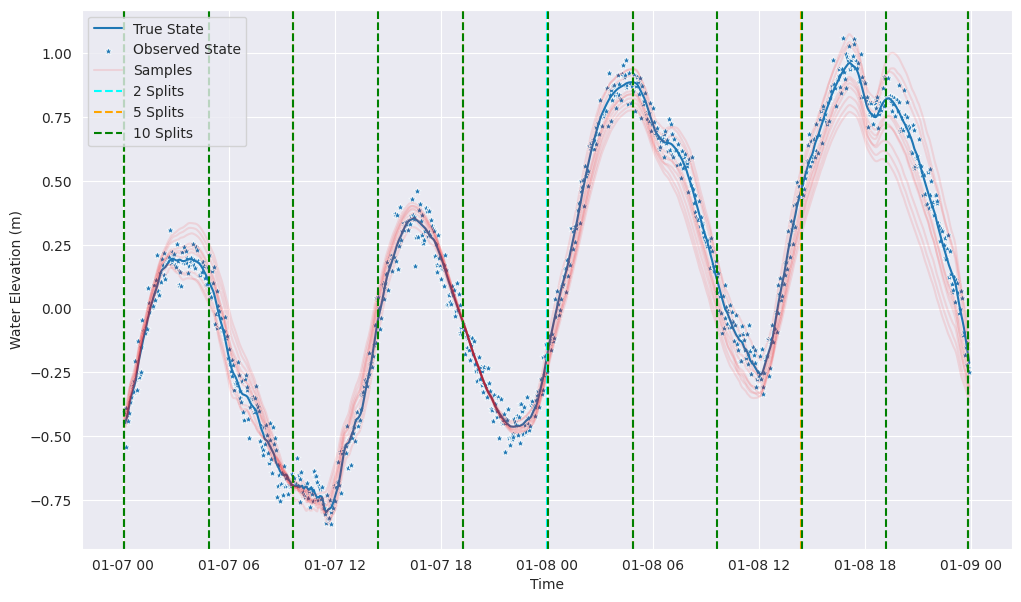

In [79]:
intervals_2 = split_range(t3_mask, 2)
intervals_5 = split_range(t3_mask, 5)
intervals_10 = split_range(t3_mask, 10)

plot_intervals = [
    ("2 Splits", {"color": "cyan", "linestyle": "--"}, intervals_2),
    ("5 Splits", {"color": "orange", "linestyle": "--"}, intervals_5),
    ("10 Splits", {"color": "green", "linestyle": "--"}, intervals_10),
]

plot_state(data_df, samples_df, t3_mask, plot_intervals=plot_intervals)
plt.savefig('adcirc_time_window_splits.png')

In [81]:
pca_2 = PCAMUDProblem(samples_df, measurements, std_dev)
pca_2.solve_it(pca_splits=intervals_2, pca_components=[[0, 1]], exp_thresh=1e10)
pca_2.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask,i
0,1.18267,4.059156,0.078406,0.002391,251,"[0, 1]","range(2774, 3252)",0
0,0.08369,4.475814,0.069212,0.002584,439,"[0, 1]","range(3253, 3731)",1


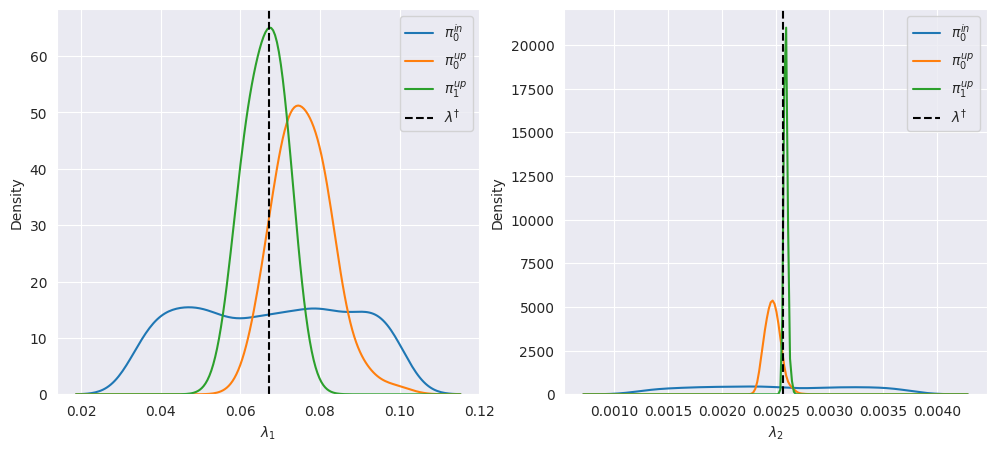

In [82]:
plot_iterations(pca_2, plot_idxs=[0, 1], lam_true=full_ds["lam_ref"])
plt.savefig('adcirc_lam_density_2_splits.png')

In [83]:
pca_5 = PCAMUDProblem(samples_df, measurements, std_dev)
pca_5.solve_it(pca_splits=intervals_5, pca_components=[[0]], exp_thresh=0.9)
pca_5.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask,i
0,1.101356,2.268199,0.050972,0.002684,683,[0],"range(2774, 2965)",0
0,0.362811,1.905286,0.061655,0.002603,44,[0],"range(2966, 3157)",1
0,1.043999,0.631217,0.061655,0.002603,44,[0],"range(3158, 3349)",2
0,1.078671,0.208902,0.061655,0.002603,44,[0],"range(3350, 3540)",3
0,1.702995,0.842278,0.061655,0.002603,44,[0],"range(3541, 3731)",4


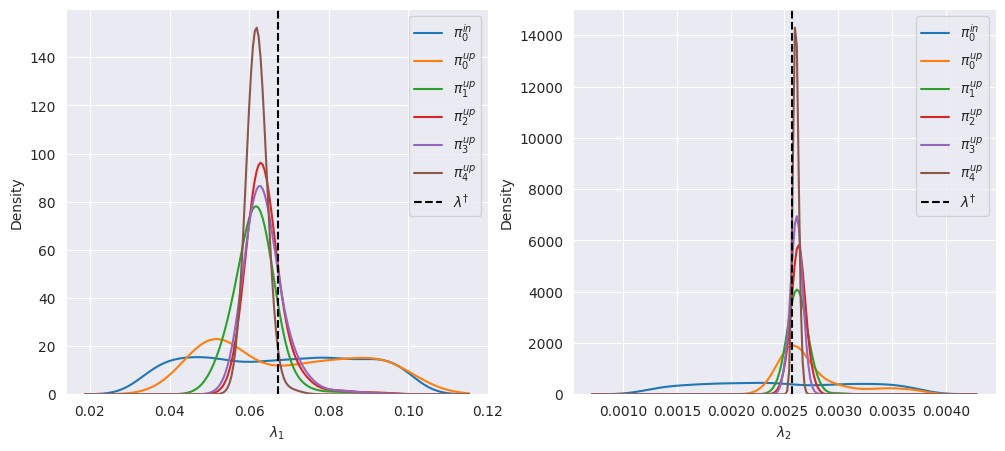

In [84]:
plot_iterations(pca_5, plot_idxs=range(5), lam_true=full_ds["lam_ref"])
plt.savefig('adcirc_lam_density_5_splits.png')

In [85]:
pca_10 = PCAMUDProblem(samples_df, measurements, std_dev)
pca_10.solve_it(pca_splits=intervals_10, pca_components=[[0]], exp_thresh=0.9)
pca_10.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask,i
0,1.134164,1.587927,0.082026,0.002509,838,[0],"range(2774, 2869)",0
0,0.944584,1.080946,0.087825,0.002599,12,[0],"range(2870, 2965)",1
0,0.874798,1.344690,0.063742,0.002642,377,[0],"range(2966, 3061)",2
0,0.650787,1.277293,0.063742,0.002642,377,[0],"range(3062, 3157)",3
0,0.726851,0.696455,0.063742,0.002642,377,[0],"range(3158, 3253)",4
0,0.734808,0.600776,0.063742,0.002642,377,[0],"range(3254, 3349)",5
0,0.824836,0.688794,0.071724,0.002557,877,[0],"range(3350, 3445)",6
0,1.329152,0.285436,0.071724,0.002557,877,[0],"range(3446, 3541)",7
0,0.895028,1.882730,0.063742,0.002642,377,[0],"range(3542, 3636)",8
0,0.453355,0.729056,0.063742,0.002642,377,[0],"range(3637, 3731)",9


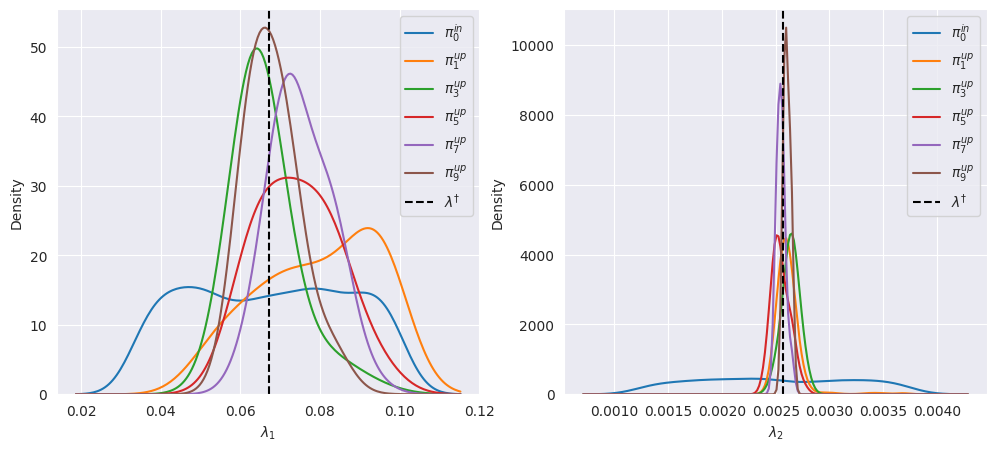

In [86]:
plot_iterations(pca_10, plot_idxs=range(1, 10, 2), lam_true=full_ds["lam_ref"])
plt.savefig('adcirc_lam_density_10_splits.png')

In [87]:
intervals_100 = split_range(t3_mask, 100)
pca_100 = PCAMUDProblem(samples_df, measurements, std_dev)
pca_100.solve_it(pca_splits=intervals_100, pca_components=[[0]], exp_thresh=1e10)
pca_100.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask,i
0,0.940181,0.731968,0.045694,0.002448,741,[0],"range(2774, 2783)",0
0,0.633479,0.070035,0.042874,0.002506,619,[0],"range(2784, 2793)",1
0,0.651450,1.813137,0.037988,0.002950,893,[0],"range(2794, 2803)",2
0,0.860606,0.575784,0.040309,0.002846,142,[0],"range(2804, 2813)",3
0,0.947144,0.516864,0.074917,0.003509,352,[0],"range(2814, 2823)",4
...,...,...,...,...,...,...,...,...
0,0.170482,6.783756,0.063742,0.002642,377,[0],"range(3687, 3695)",95
0,0.933347,0.255561,0.063742,0.002642,377,[0],"range(3696, 3704)",96
0,0.865360,0.240233,0.063742,0.002642,377,[0],"range(3705, 3713)",97
0,0.784824,0.468480,0.063742,0.002642,377,[0],"range(3714, 3722)",98


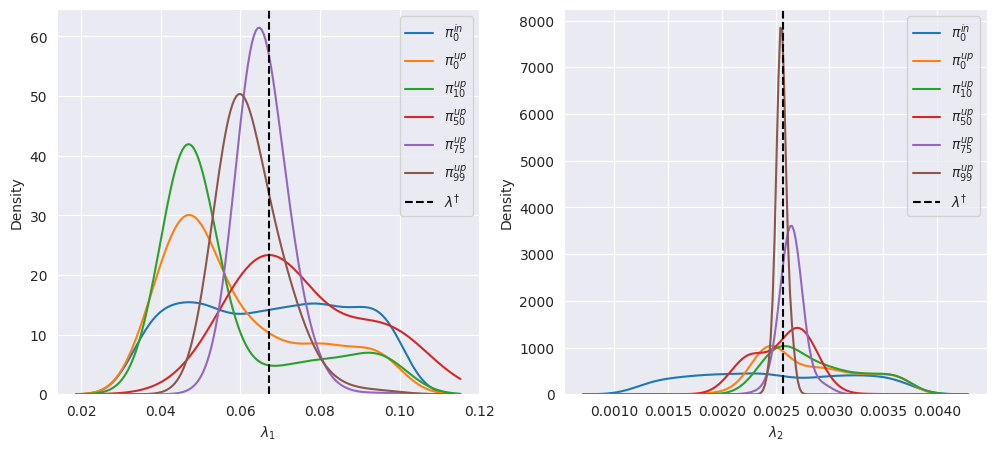

In [88]:
plot_iterations(pca_100, plot_idxs=[0, 10, 50, 75, 99], lam_true=full_ds["lam_ref"])
plt.savefig('adcirc_lam_density_100_splits.png')

# Repeating Trials

In [92]:
import importlib

from alive_progress import alive_bar
from pydci.consistent_bayes import PCAMUDProblem
from pydci.log import disable_log, enable_log, logger
from pydci.utils import get_df

importlib.reload(PCAMUDProblem)


def process_result(prob, lam_true):
    # Calculate L2 error and Covariance for each
    res = prob.it_results.copy()
    mud_points = get_df(prob.it_results, "lam_MUD", 2)
    l2_errs = np.linalg.norm(mud_points - lam_true, axis=1)
    l2_errs = np.linalg.norm(mud_points - lam_true, axis=1)
    covs = []
    res["l2_err"] = l2_errs

    # Get covariance
    if not any(prob.pca_states["ratio"] == 0.0):
        lam_matrix = get_df(prob.state, "lam", 2)
        for idx, state in prob.pca_states.groupby("iteration"):
            cov = np.cov(lam_matrix.T, aweights=state["ratio"])
            covs.append([cov[0][0], cov[1][1]])
        covs = np.array(covs)
        res["lam_0_cov"] = covs[:, 0]
        res["lam_1_cov"] = covs[:, 1]
    else:
        res["lam_0_cov"] = np.nan
        res["lam_1_cov"] = np.nan

    mud_states = get_df(
        prob.state.iloc[prob.it_results["MUD_idx"].values], "q_lam", prob.n_qoi
    )
    res["state_err"] = np.linalg.norm((mud_states.T - measurements).T, axis=1)

    res["i"] = res["i"] + 1
    res["ts"] = [
        full_ds["times"][int(x.split(",")[-1][1:-1])] for x in res["pca_mask"].values
    ]
    first = res.iloc[[0]].copy()
    first["i"] = 0
    first["ts"] = [full_ds["times"][eval(res["pca_mask"].values[0])[0]]]
    res = pd.concat([first, res])
    res["splits"] = res["i"].max()
    res["n_samples"] = prob.n_samples
    return res


def split_scan(
    n_splits, std_dev=0.05, num_samples=[999], pca_components=[[0]], n_trials=10
):
    all_results = []

    with alive_bar(
        n_trials * len(num_samples) * len(n_splits),
        title=f"Scanning {n_splits} using {num_samples}",
        force_tty=True,
    ) as bar:
        for n in range(n_trials):
            for n_samples in num_samples:
                data_df, samples_df, measurements = build_dataset(
                    std_dev=std_dev, num_samples=n_samples
                )
                for ns in n_splits:
                    intervals = split_range(t3_mask, ns)
                    pca = PCAMUDProblem.PCAMUDProblem(samples_df, measurements, std_dev)
                    pca.solve_it(
                        pca_splits=intervals,
                        pca_components=pca_components,
                        exp_thresh=1e10,
                    )
                    res = process_result(pca, full_ds["lam_ref"])
                    res['n_iters'] = ns
                    all_results.append(res)
                    bar()

    all_results = pd.concat(all_results)

    return all_results


def incremental_scan(
    num_splits=100,
    std_dev=0.05,
    num_samples=[999],
    exp_thresh=1e10,
    pca_components=[[0, 1]],
    n_trials=10,
):
    all_results = []

    with alive_bar(
        n_trials * len(num_samples) * num_splits,
        title=f"Scanning {num_splits} using {num_samples}",
        force_tty=True,
    ) as bar:
        for n in range(n_trials):
            for n_samples in num_samples:
                data_df, samples_df, measurements = build_dataset(
                    std_dev=std_dev, num_samples=n_samples
                )
                intervals = split_range(t3_mask, num_splits)
                start = intervals[0][0]
                for interval in intervals:
                    pca = PCAMUDProblem.PCAMUDProblem(samples_df, measurements, std_dev)
                    pca.solve_it(
                        pca_splits=[range(start, max(interval))],
                        pca_components=pca_components,
                        exp_thresh=1e10,
                    )
                    all_results.append(process_result(pca, full_ds["lam_ref"]))
                    all_results[-1]['n_iters'] = 1
                    bar()

    all_results = pd.concat(all_results)

    return all_results

def plot_metric(results, metric='e_r'):
    """
    Plot metric for scan results over time.
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    results = results[
        [c for c in results.columns if c in ["i", "ts", "n_iters", "n_samples", metric]]
    ].copy()
    col_name = '(# splits, # samples)'
    results.loc[:,col_name] = [f'({x[0], x[1]})' for x in zip(results['n_iters'], results['n_samples'])]
    sns.lineplot(
        results.dropna(),
        markers=True,
        x='ts', y=metric,
        ax=ax,
        style=col_name,
        hue=col_name,
        palette='flare')
    ax.set_xlabel('Time')
    metric_labels = {
        'e_r': "$\mathbb{E}(r)$",
        'kl': "$\mathcal{D}_{KL}$",
        'l2_err': "$||\lambda^{MUD} - \lambda^{\dagger}||_{\ell_2}$",
        'state_err': "$||Q(\lambda^{MUD}) - Q(\lambda^{\dagger})||_{\ell_2}$",
        'lam_0_cov': "$\sigma_0$",
        'lam_1_cov': "$\sigma_1$",
    }
    ax.set_ylabel(metric_labels[metric])

In [ ]:
split_results = split_scan(
    n_splits=[10, 100],
    std_dev=std_dev,
    n_trials=10,
    num_samples=[10, 100, 999],
    pca_components=[[0]],
)

In [29]:
inc_scan = incremental_scan(
    num_splits=50, std_dev=std_dev, n_trials=10, num_samples=[10, 100, 999]
)

on 931: /tmp/ipykernel_32781/1871783328.py:24: RuntimeWarning: Degrees of freedom <= 0 for slice
          cov = np.cov(lam_matrix.T, aweights=state["ratio"])
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
          c *= np.true_divide(1, fact)


on 932: /tmp/ipykernel_32781/1871783328.py:24: RuntimeWarning: Degrees of freedom <= 0 for slice
          cov = np.cov(lam_matrix.T, aweights=state["ratio"])
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
          c *= np.true_divide(1, fact)


Scanning 50 using [10, 100, 999] |████████████████████████████████████████| 1500/1500 [100%] in 12:24.5 (2.01/s)        


In [31]:
all_results = pd.concat([inc_scan, split_results])
all_results

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask,i,l2_err,lam_0_cov,lam_1_cov,state_err,ts,splits,n_samples,n_iters
0,1.104870,0.699860,0.073284,0.002428,8,"[0, 1]","range(2774, 2792)",0,0.006042,0.000367,7.088958e-08,7.448247,2018-01-07 00:03:00,1,10,1
0,1.104870,0.699860,0.073284,0.002428,8,"[0, 1]","range(2774, 2792)",1,0.006042,0.000367,7.088958e-08,7.448247,2018-01-07 00:57:00,1,10,1
0,1.708122,0.517806,0.073284,0.002428,8,"[0, 1]","range(2774, 2812)",0,0.006042,0.000429,6.667669e-08,7.448247,2018-01-07 00:03:00,1,10,1
0,1.708122,0.517806,0.073284,0.002428,8,"[0, 1]","range(2774, 2812)",1,0.006042,0.000429,6.667669e-08,7.448247,2018-01-07 01:57:00,1,10,1
0,3.054347,0.555111,0.073284,0.002428,8,"[0, 1]","range(2774, 2832)",0,0.006042,0.000436,5.406831e-08,7.448247,2018-01-07 00:03:00,1,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.957305,0.250619,0.073284,0.002428,75,[0],"range(3687, 3695)",96,0.006042,0.000295,1.334792e-07,7.448247,2018-01-08 22:06:00,100,999,100
0,0.700991,0.732853,0.073952,0.002513,374,[0],"range(3696, 3704)",97,0.006709,0.000088,2.506910e-08,4.798507,2018-01-08 22:33:00,100,999,100
0,0.930781,0.041223,0.071684,0.002590,870,[0],"range(3705, 3713)",98,0.004441,0.000332,1.361863e-11,4.014186,2018-01-08 23:00:00,100,999,100
0,0.682182,1.121584,0.071684,0.002590,870,[0],"range(3714, 3722)",99,0.004441,0.000350,9.211145e-07,4.014186,2018-01-08 23:27:00,100,999,100


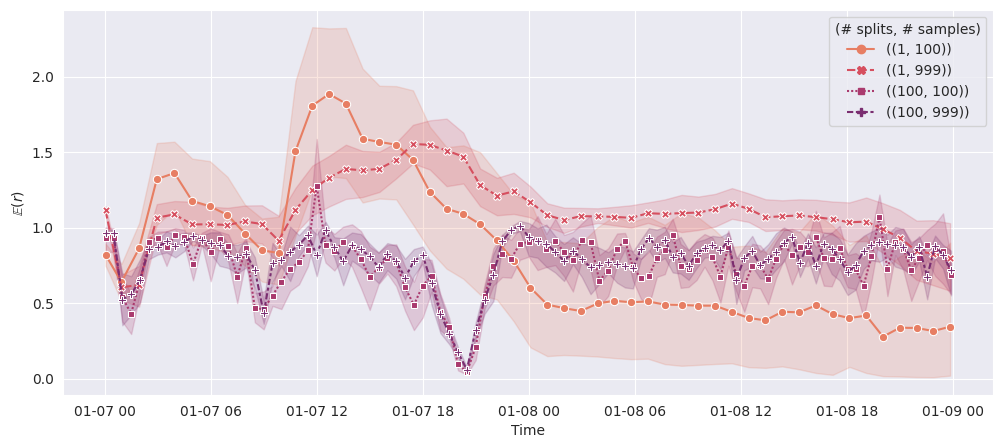

In [94]:
# TODO: Change legend labels -> Stress 1 split uses 2 component map. 
plot_metric(
    all_results[
        ((all_results["splits"] == 1) | (all_results["splits"] == 100))
        & ((all_results["n_samples"] == 100) | (all_results["n_samples"] == 999))
    ],
    metric='e_r'
)

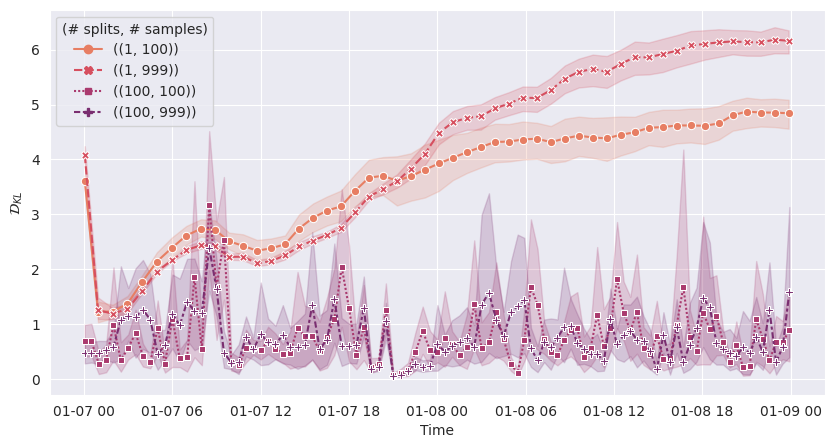

In [91]:
plot_metric(
    all_results[
        ((all_results["splits"] == 1) | (all_results["splits"] == 100))
        & ((all_results["n_samples"] == 100) | (all_results["n_samples"] == 999))
    ],
    metric='kl'
)

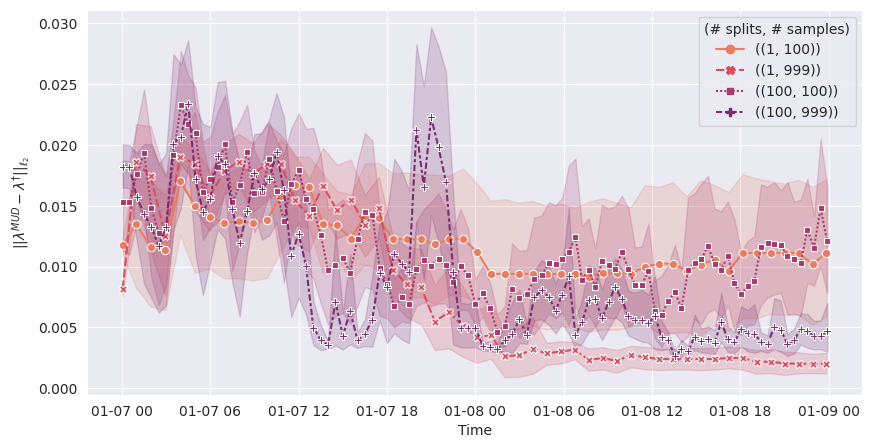

In [50]:
plot_metric(
    all_results[
        ((all_results["splits"] == 1) | (all_results["splits"] == 100))
        & ((all_results["n_samples"] == 100) | (all_results["n_samples"] == 999))
    ],
    metric='l2_err'
)

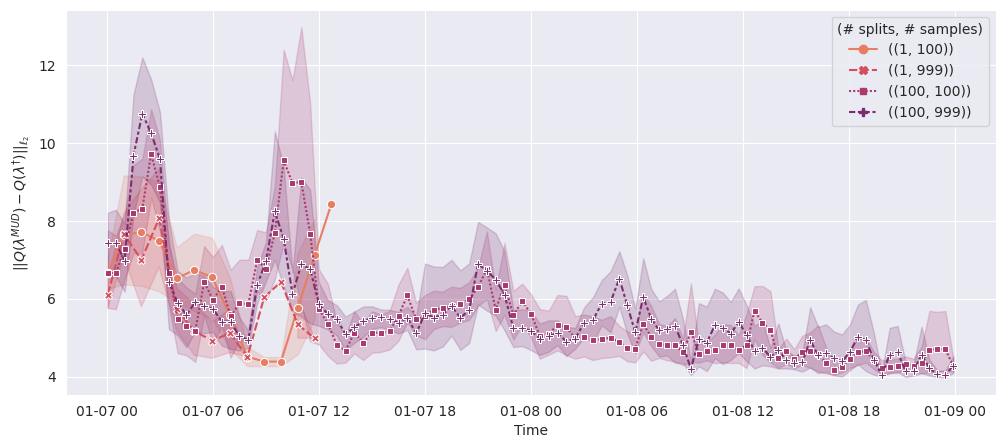

In [95]:
plot_metric(
    all_results[
        ((all_results["splits"] == 1) | (all_results["splits"] == 100))
        & ((all_results["n_samples"] == 100) | (all_results["n_samples"] == 999))
    ].dropna(),
    metric='state_err'
)

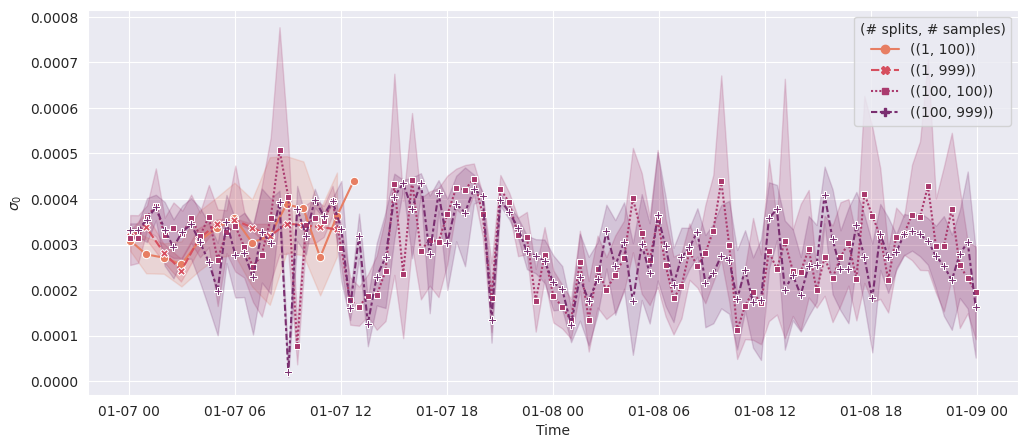

In [96]:
plot_metric(
    all_results[
        ((all_results["splits"] == 1) | (all_results["splits"] == 100))
        & ((all_results["n_samples"] == 100) | (all_results["n_samples"] == 999))
    ].dropna(),
    metric='lam_0_cov'
)

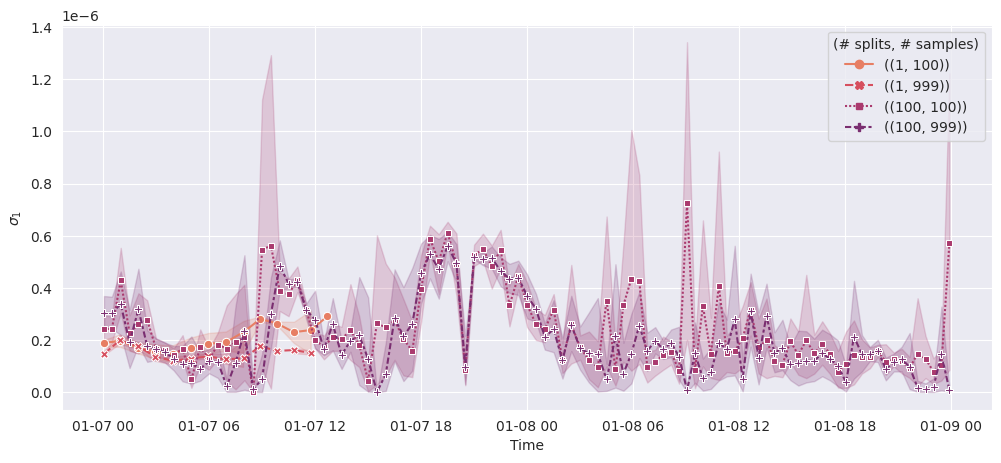

In [97]:
plot_metric(
    all_results[
        ((all_results["splits"] == 1) | (all_results["splits"] == 100))
        & ((all_results["n_samples"] == 100) | (all_results["n_samples"] == 999))
    ].dropna(),
    metric='lam_1_cov'
)

## Using Less Samples

In [80]:
num_samples = 100
inc_scan = incremental_scan(
    num_splits=100, std_dev=std_dev, n_trials=10, num_samples=num_samples
)
split_results = split_scan(
    [5, 10, 100], std_dev=std_dev, n_trials=10, num_samples=num_samples
)
all_results = pd.concat([inc_scan, split_results])

Scanning 100 using 100 |████████████████████████████████████████✗︎ (!) 1060/1000 [106%] in 7:31.2 (2.35/s)               ███████████████████████████████████▉    | ▅▃▁ 898/1000 [90%] in 6:22 (~44s, 2.4/s) 


on 7: /opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
        avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


on 8: /opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
        avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in divide
        avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: overflow encountered in multiply
        fact = w_sum - ddof*sum(w*aweights)/w_sum
/opt/conda/envs/fenix/lib/python3.10/site-pac

Scanning [5, 10, 100] using 100 |████████████████████████████████████████| 30/30 [100%] in 36.9s (0.80/s)               


# Selective Intervals

Using weights only from intervals with good E(r) values.

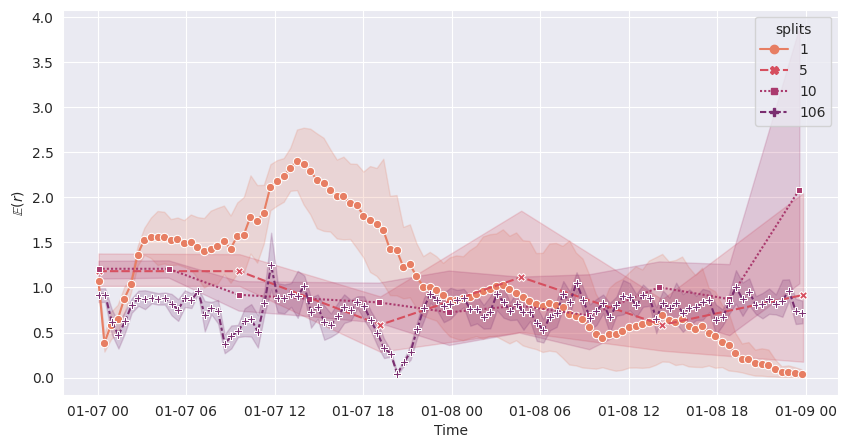

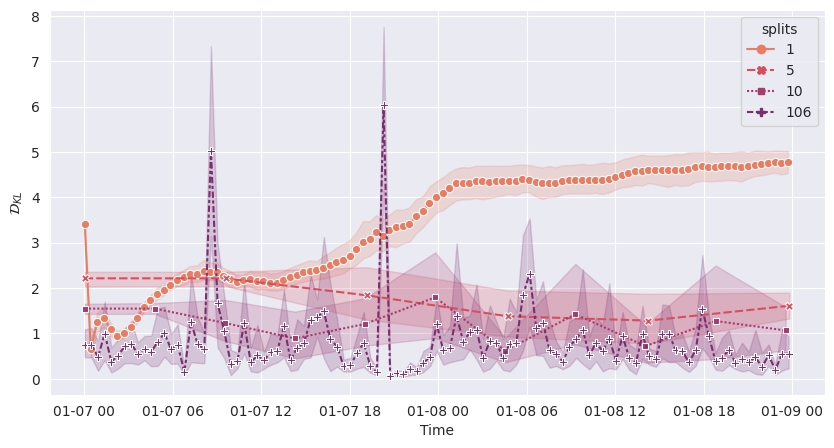

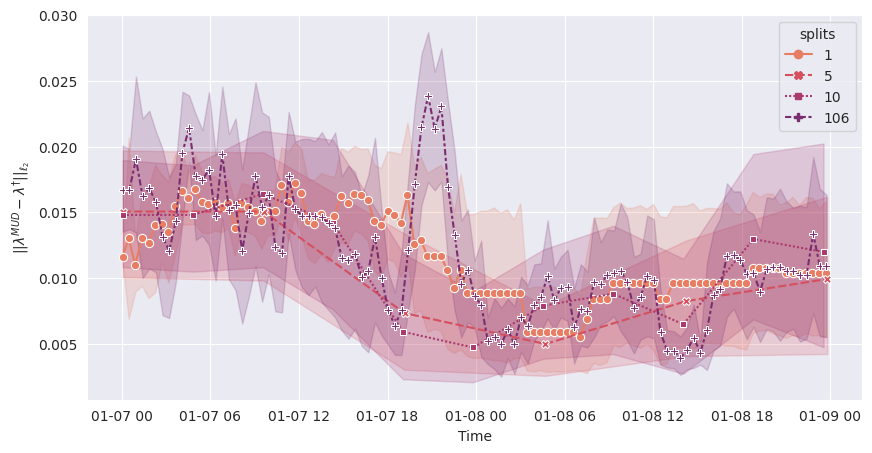

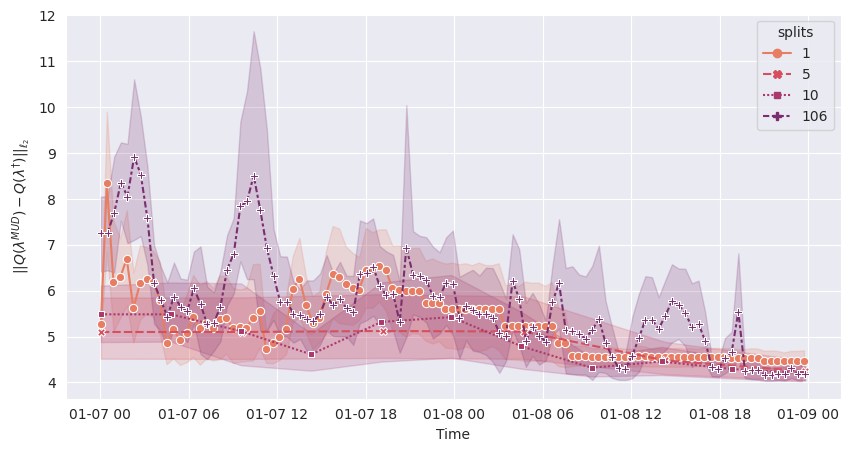

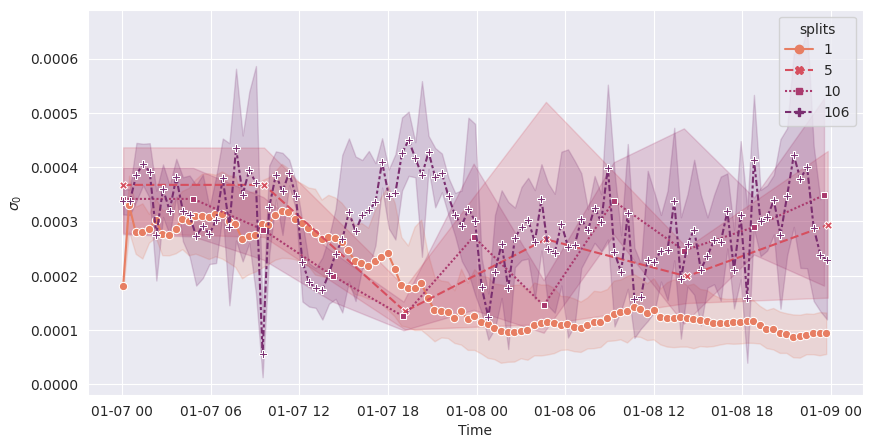

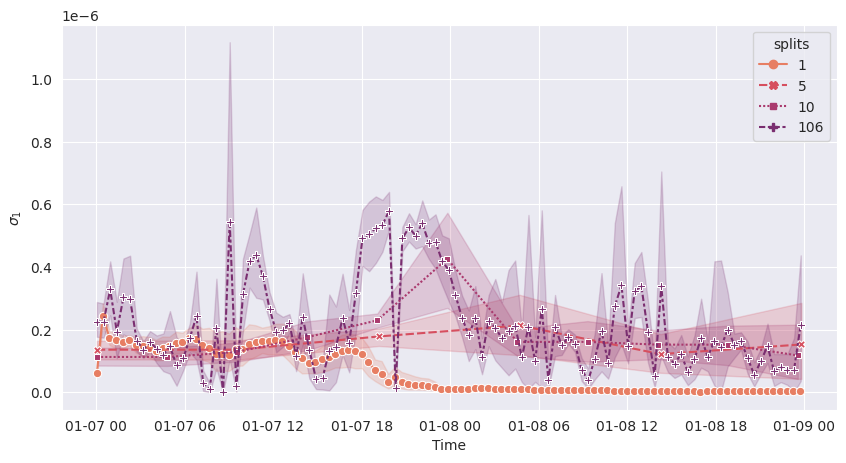

In [81]:
plot_scan_results(all_results)

In [ ]:
thresh = 0.95
good_e_r = pca_100.it_results["i"][
    (pca_100.it_results["e_r"] > 1 - thresh) & (pca_100.it_results["e_r"] < 1 + thresh)
].values
weights = []
for gi in good_e_r:
    weights.append(
        pca_100.pca_states[pca_100.pca_states["iteration"] == gi]["ratio"].values
    )

In [ ]:
from pydci.utils import get_df

mud_pt = get_df(
    pca_100.state.iloc[[np.argmax(np.prod(np.array(weights), axis=0))]], "lam", 2
)
mud_pt, full_ds["lam_ref"]

In [ ]:
np.linalg.norm(mud_pt - full_ds["lam_ref"])

In [ ]:
sns.kdeplot(data=pca_100.state, x="lam_0", weights=np.prod(np.array(weights), axis=0))

In [ ]:
sns.kdeplot(data=pca_100.state, x="lam_1", weights=np.prod(np.array(weights), axis=0))

In [ ]:
ratios = (
    pca_100.pca_states[["ratio"]]
    .iloc[[x in good_e_r for x in pca_100.pca_states["iteration"]]]
    .values.reshape(pca_100.n_samples, len(good_e_r))
    .T
)

In [ ]:
pca_100.pca_states

In [ ]:
ratios[0] == pca_100.pca_states[pca_100.pca_states["iteration"] == 0]["ratio"]

In [ ]:
sns.kdeplot(
    data=pca_100.pca_states[pca_100.pca_states["iteration"] == 0],
    x="lam_0",
    weights="ratio",
)

In [ ]:
sns.kdeplot(
    data=pca_100.pca_states[pca_100.pca_states["iteration"] == 0],
    x="lam_0",
    weights=ratios[0],
)

In [ ]:
cols = ["ts", "splits", "n_samples"]
metrics = ["e_r", "kl", "l2_err"]
all_dfs = []
for metric in metrics:
    df = split_results[cols].copy()
    df["metric_val"] = split_results[metric].values
    df["metric"] = metric
    all_dfs.append(df)

all_dfs = pd.concat(all_dfs).dropna()
all_dfs["(# splits, # samples)"] = [
    f"({x[0]},{x[1]})"
    for x in zip(all_dfs["splits"].values, all_dfs["n_samples"].values)
]
all_dfs

,ts,splits,n_samples,metric_val,metric,"(# splits, # samples)"
0,2018-01-07 00:03:00,2,20,1.582801,e_r,"(2,20)"
0,2018-01-07 09:36:00,2,20,1.582801,e_r,"(2,20)"
0,2018-01-07 19:12:00,2,20,0.001413,e_r,"(2,20)"
0,2018-01-07 00:03:00,3,20,0.098233,e_r,"(3,20)"
0,2018-01-07 04:48:00,3,20,0.098233,e_r,"(3,20)"
...,...,...,...,...,...,...
0,2018-01-08 20:18:00,96,20,0.006709,l2_err,"(96,20)"
0,2018-01-08 20:45:00,96,20,0.006709,l2_err,"(96,20)"
0,2018-01-08 21:12:00,96,20,0.006709,l2_err,"(96,20)"
0,2018-01-08 21:39:00,96,20,0.006709,l2_err,"(96,20)"
